# #0 Journal paper critique

# #1 Reproduce figure with $\textrm{Bokeh}$

# #2 Reproduce figure in $\textrm{matplotlib}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

load data

In [2]:
data_dir = 'hw_2_data/'

In [3]:
ny_temp = np.loadtxt(data_dir + 'ny_temps.txt', skiprows=1)
google_stock = np.loadtxt(data_dir + 'google_data.txt', skiprows=1)
yahoo_stock = np.loadtxt(data_dir + 'yahoo_data.txt', skiprows=1)

In [4]:
google_t, google_v = google_stock[:, 0], google_stock[:, 1]
yahoo_t, yahoo_v = yahoo_stock[:, 0], yahoo_stock[:, 1]
ny_t, ny_v = ny_temp[:, 0], ny_temp[:, 1]

In [5]:
from matplotlib.ticker import MultipleLocator

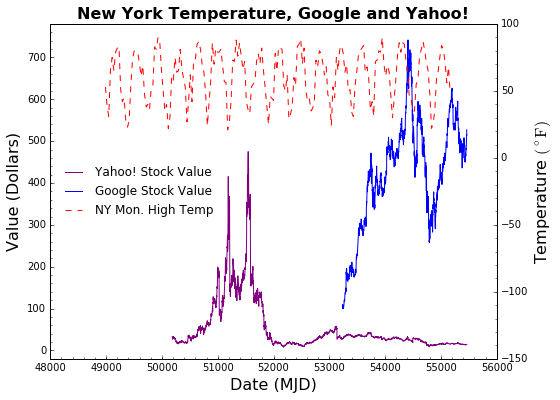

In [6]:
fs=16
fig, ax1 = plt.subplots(figsize=[8,6])

lns1 = ax1.plot(yahoo_t, yahoo_v, 'purple', label='Yahoo! Stock Value')
lns2 = ax1.plot(google_t, google_v, 'b-', label='Google Stock Value')
ax1.set_xlabel('Date (MJD)', fontsize=fs)
ax1.set_ylabel('Value (Dollars)', fontsize=fs)

ax1.set_ylim([-20, 780])
ax1.set_xlim([49000, 55000])

# add minor ticks
ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.yaxis.set_minor_locator(MultipleLocator(20))

# set font for title
font = {'family': 'sans-serif','color':  'black', 
        'weight': 'bold','size': fs}
ax1.set_title('New York Temperature, Google and Yahoo!', fontdict=font)

# turn off major and minor ticks from upper x axis
ax1.tick_params(axis='x', which='both', top='off')        

ax2 = ax1.twinx()
lns3 = ax2.plot(ny_t, ny_v, 'r--', label='NY Mon. High Temp')
ax2.set_ylabel('Temperature $(^\circ \mathrm{F})$', fontsize=fs)
ax2.set_ylim([-150, 100])
ax2.yaxis.set_minor_locator(MultipleLocator(10))

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', frameon=False)

plt.show()

# #3 Generic "Brushing" code

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# %matplotlib inline

Read dataset with many rows and multiple columns (variables/parameters).

In [8]:
data_dir = 'hw_2_data/'
filename = data_dir + 'flowers.csv'

In [9]:
!tail -n 5 hw_2_data/flowers.csv

6.7,3.0,5.2,2.3,virginica
6.3,2.5,5.0,1.9,virginica
6.5,3.0,5.2,2.0,virginica
6.2,3.4,5.4,2.3,virginica
5.9,3.0,5.1,1.8,virginica


In [10]:
# datatype
dt = [('sepalLength', 'f4'), ('sepalWidth', 'f4'),
     ('petalLength', 'f4'), ('petalWidth', 'f4'), ('species', 'S10')]

names = ['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'species']
formats = ['f4', 'f4', 'f4', 'f4', 'S10']
dt = {'names': names, 'formats':formats}
# dataset
ds = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=dt)

data brushing

In [11]:
# define colors for different species
blue = [0, 0, 1, 0.75]
red = [1, 0, 0, 0.75]
green = [0, 0.5, 0, 0.75]
grey = [0.75, 0.75, 0.75, 0.5]
colorTable = {b'setosa': red, b'versicolor': blue, b'virginica': green}

class Brushing(object):
 
    
    def __init__(self):
        """
        Constructor of Brushing object
        - make panel plots
        - implementation requires that m, n >= 2
        - set default values of figure, axes handle
        - connect figure to press, move and release events
        """
        self.m = 4
        self.n = 4
        fig, axes = plt.subplots(self.m, self.n, sharey='row', 
                                 sharex='col', figsize=[10, 10])
        self.axes = np.array(fig.axes).reshape(self.m, self.n)

        self.scatters = []
        for i, var_i in enumerate(names[:self.m]):
            for j, var_j in enumerate(names[:self.n]):
                data_i = ds[var_i]
                data_j = ds[var_j]
                ax = axes[i, j]
                colors = np.array([colorTable[s] for s in ds['species']])
                sc = ax.scatter(data_j, data_i, c=colors)
                self.scatters += [sc]
                sc.set_edgecolors(colors)
                if i == j:
                    ax.text(0.1, 0.8, var_i, transform=ax.transAxes)
        self.scatters = np.array(self.scatters).reshape(self.m, self.n)
        self.rect = None
        self.fig = fig
        
        self.x0 = None
        self.y0 = None
        self.x1 = None
        self.y1 = None
        
        self.ax = None
        self.ax_ij = None
        self.press = None
        
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def selected(self):
        """
        return boolean array for indices of the selected data points
        """
        i, j = self.ax_ij
        data_i = ds[names[i]]
        data_j = ds[names[j]]
        xmin = min(self.x0, self.x1)
        xmax = max(self.x0, self.x1)
        ymin = min(self.y0, self.y1)
        ymax = max(self.y0, self.y1)
        
        if xmin == xmax and ymin == ymax:
            selected=np.empty(len(data_i), dtype=bool)
            selected.fill(True)
            return selected
        return (data_j > xmin) & (data_j < xmax) & \
            (data_i > ymin) & (data_i < ymax)
    
    
    def on_press(self, event):
        """
        when mouse press release
        - draw/redraw triangle
        """        
        if not self.rect:
            self.rect = Rectangle((0,0), 0, 0, facecolor='grey', alpha = 0.2)
            self.ax = event.inaxes
            self.ax.add_patch(self.rect)
            self.ax_ij = self.which_axis()
        if self.ax != event.inaxes:
            self.ax = event.inaxes
            self.rect.set_visible(False)
            del self.rect
            self.rect = Rectangle((0,0), 0, 0, facecolor='grey', alpha = 0.2)
            self.ax.add_patch(self.rect)
            self.ax_ij = self.which_axis()
        else:
            self.rect.set_width(0)
            self.rect.set_height(0)

        self.press = True
        self.x0 = event.xdata
        self.y0 = event.ydata

    def on_release(self, event):
        """
        when mouse press release
        - redraw triangle
        - reset colors of data points
        """

        self.press = None
        if event.inaxes != self.rect.axes: return
        self.x1 = event.xdata
        self.y1 = event.ydata
        self.rect.set_width(self.x1 - self.x0)
        self.rect.set_height(self.y1 - self.y0)
        self.rect.set_xy((self.x0, self.y0))
        self.set_color()
                
        self.fig.canvas.draw()
    
    def on_motion(self, event):
        """
        when mouse move
        - redraw triangle
        - reset colors of data points
        """
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        
        self.x1 = event.xdata
        self.y1 = event.ydata
        self.rect.set_width(self.x1 - self.x0)
        self.rect.set_height(self.y1 - self.y0)
        self.rect.set_xy((self.x0, self.y0))
        
        self.set_color()

        self.fig.canvas.draw()
    
    def which_axis(self):
        """
        find the (i, j) index of the subplot selected by mouse event
        """
        for i in range(self.m):
            for j in range(self.n):
                if self.axes[i,j] is self.ax:
                    return (i, j)
        return 


    def set_color(self):
        """
        set color of scattered plots
        - selected data points keep the colors
        - other data points are shaded in grey
        """
        selected = self.selected()
        for i, var_i in enumerate(names[:self.m]):
            for j, var_j in enumerate(names[:self.n]):
                colors = np.array([colorTable[s] for s in ds['species']])
                colors[~selected, :] = grey
                sc = self.scatters[i,j]
                sc.set_facecolors(colors)
                sc.set_edgecolors(colors)
        return

###  <font color='red'> ipython widget make it too slow, so please coment the following 3 lines out to play interactively </font> 

<IPython.core.display.Javascript object>


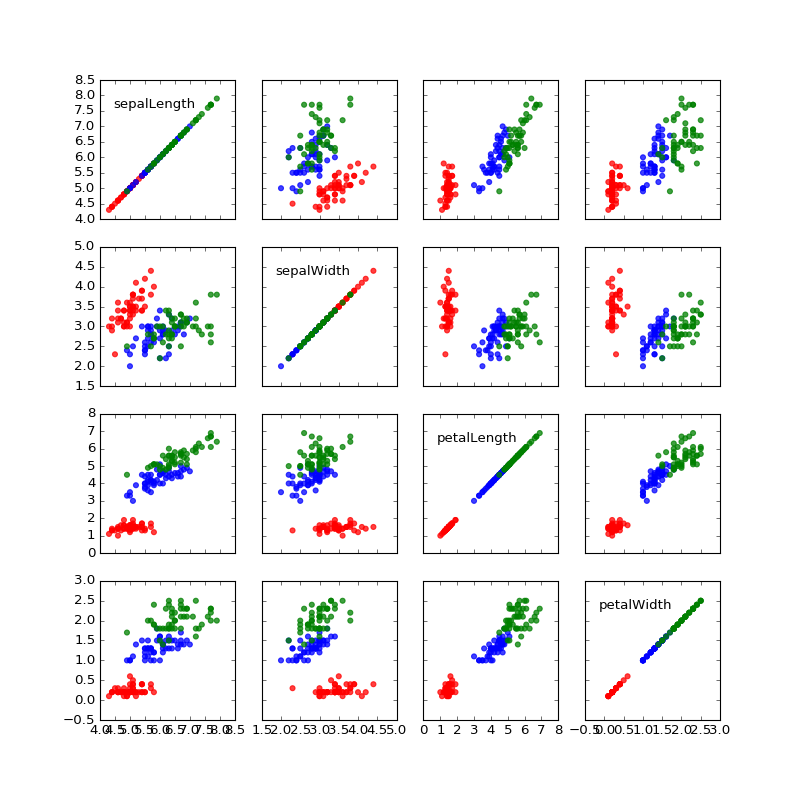

In [12]:
import ipywidgets as widgets
%matplotlib notebook
w = widgets.HTML()


a = Brushing()
plt.show()